# Activity 3: Analyzing SLEAP outputs

This notebook accompanies the [Activity 3 page](https://github.com/talmolab/sleap-tutorial-uo/blob/main/analysis.md). Check it out before getting started here.

If you're running this on Google Colab, uncomment and run the following cell to set things up:

In [ ]:
# !pip install sleap==1.2.0a2
# !git clone https://github.com/talmolab/sleap-tutorial-uo
# !cp -r sleap-tutorial-uo/data/ data/

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

import sleap  # this is not required if loading from analysis files
sleap.versions()

SLEAP: 1.2.0a2
TensorFlow: 2.7.0
Numpy: 1.19.5
Python: 3.7.11
OS: Windows-10-10.0.19041-SP0


## 1a. Loading the data (from an analysis file)

[HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a common format for storing numerical data such as large arrays.

SLEAP can export the results of tracking to these files which can then be read in other software and languages including:

- [MATLAB](https://www.mathworks.com/help/matlab/hdf5-files.html)
- [R](https://www.bioconductor.org/packages/devel/bioc/vignettes/rhdf5/inst/doc/rhdf5.html)
- [Python](https://docs.h5py.org/en/stable/)

We'll be using the Python interface in this example.

We'll start by defining a little utility function that walks through the datasets stored in the HDF5 file and prints out their shape and data type.

In [2]:
def describe_hdf5(filename, attrs=True):
    """Utility to describe all items in an HDF5 file."""
    def desc(k, v):
        if type(v) == h5py.Dataset:
            print(f"[ds]  {v.name}: {v.shape} | dtype = {v.dtype}")
            if attrs and len(v.attrs) > 0:
                print(f"      attrs = {dict(v.attrs.items())}")
        elif type(v) == h5py.Group:
            print(f"[grp] {v.name}:")
            if attrs and len(v.attrs) > 0:
                print(f"      attrs = {dict(v.attrs.items())}")

    with h5py.File(filename, "r") as f:
        f.visititems(desc)
        
describe_hdf5("data/predictions.analysis.h5")

[ds]  /instance_scores: (2, 1350) | dtype = float64
[ds]  /node_names: (3,) | dtype = |S10
[ds]  /point_scores: (2, 3, 1350) | dtype = float64
[ds]  /track_names: (2,) | dtype = |S10
[ds]  /track_occupancy: (1350, 2) | dtype = uint8
[ds]  /tracking_scores: (2, 1350) | dtype = float64
[ds]  /tracks: (2, 2, 3, 1350) | dtype = float64


As we can see here, the `/tracks` dataset contains what we're looking for: the pose coordinates.

Let's load it from the file into a numpy array:

In [3]:
with h5py.File("data/predictions.analysis.h5", "r") as f:
    tracks = f["tracks"][:]

tracks = np.transpose(tracks, [3, 0, 2, 1])
tracks.shape

(1350, 2, 3, 2)

Note that we swap the order of the dimensions so that we have the array in `(frames, tracks, nodes, 2)` order. The last axis corresponds to the x- and y-coordinates.

Next we'll visualize these tracks in step 2 below.

## 1b. Loading the data (from a `.slp` labels file)

For more routine and flexible use, you may prefer to use SLEAP's APIs to work with the `.slp` project files directly without first exporting to an analysis HDF5 file.

Let's give it a spin and get the same numpy array we extracted from the analysis HDF5 file above:

In [4]:
labels = sleap.load_file("data/predictions.slp")
labels

Labels(labeled_frames=1350, videos=1, skeletons=1, tracks=2)

In [5]:
tracks = labels.numpy()
tracks.shape

(1350, 2, 3, 2)

Note that here we just use the [`Labels.numpy()`](https://sleap.ai/api/sleap.io.dataset.html#sleap.io.dataset.Labels.numpy) utility, but if you need finer control, you can access labeled frames and instances individually:

In [6]:
# Labeled frames can be accessed using [] indexing
labeled_frame = labels[100]
labeled_frame

LabeledFrame(video=MediaVideo('data\fly_clip.mp4'), frame_idx=100, instances=2)

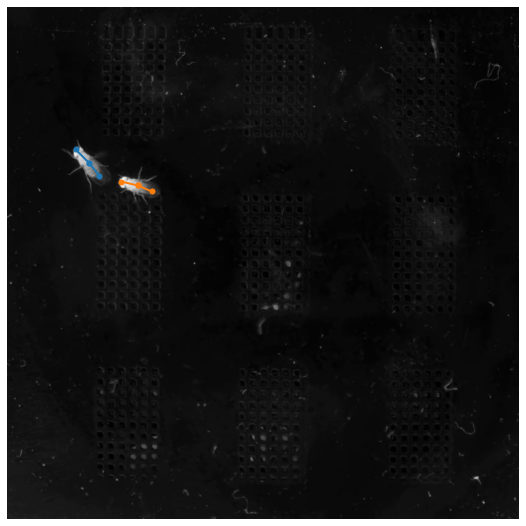

In [7]:
# Visualize the labeled frame
labeled_frame.plot(scale=0.5)

In [8]:
# Instances from a labeled frame can be converted to numpy arrays together...
labeled_frame.numpy().shape

(2, 3, 2)

In [9]:
# ... or individually:
predicted_instance = labeled_frame[0]
predicted_instance.numpy()

rec.array([[136.484375  , 284.83029175],
           [164.01121521, 312.51412964],
           [183.62976074, 337.1496582 ]],
          dtype=float64)

# 2. Visualizing results

Whether you're reading the data from an analysis HDF5 file or a SLEAP project file, we can now access the positional data however we want.

Let's try a couple of visualizations:

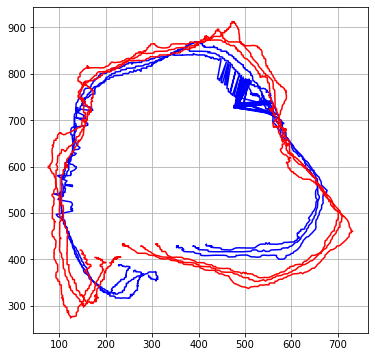

In [10]:
# Trajectory across for all frames
plt.figure(figsize=(6, 6))
for j in range(tracks.shape[2]):
    plt.plot(tracks[:, 0, j, 0], tracks[:, 0, j, 1], "b-")
for j in range(tracks.shape[2]):
    plt.plot(tracks[:, 1, j, 0], tracks[:, 1, j, 1], "r-")
plt.grid(True);

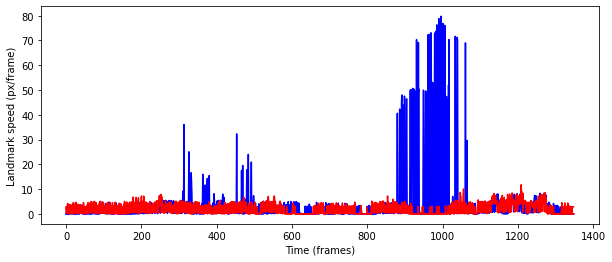

In [11]:
# Landmark-wise speed over time
speeds = np.linalg.norm(np.diff(tracks, axis=0), axis=3)  # (time, tracks, nodes)

plt.figure(figsize=(10, 4))
for j in range(tracks.shape[2]):
    plt.plot(speeds[:, 0, j], "b-")
for j in range(tracks.shape[2]):
    plt.plot(speeds[:, 1, j], "r-")
plt.xlabel("Time (frames)")
plt.ylabel("Landmark speed (px/frame)");